In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models

## Test with complex valued inputs & outputs (dummy data)

(1) Dummy data

In [3]:
def dummy_data(n, d):
    rng = np.random.default_rng()
    in_real, in_imag = rng.random((2, n, d))
    out_real, out_imag = rng.random((2, n, d-2))
    inputs = in_real + 1j* in_imag
    outputs = out_real + 1j* out_imag
    return inputs, outputs

n_train = 20
n_vali = 5
n_test = 5
d = 4
# Data 
train_in, train_out = dummy_data(n_train, d)
vali_in, vali_out = dummy_data(n_vali, d)
test_in, test_out = dummy_data(n_test, d)

print('Datasets')
print(train_in.shape)
print(train_out.shape)
print(test_out.shape)

Datasets
(20, 4)
(20, 2)
(5, 2)


In [13]:
# Dummy string inputs
text = 'dummy_arr.npy'
train_str = np.reshape(np.repeat(np.array([text]), n_train), (n_train, 1))
test_str = np.reshape(np.repeat(np.array([text]), n_test), (n_test, 1))
print(test_str.shape)

(5, 1)


In [4]:
train_out[0, :].shape

(4,)

In [19]:
np.save('dummy_arr.npy', vali_in[0, :])

(2) Model building

In [15]:
# (1) Register inputs
dummy_in = keras.Input(shape = (d,), name = 'dummy_in') # dummy input
dummy_int = keras.Input(shape = (1,), name = 'dummy_int') # dummy str
# Access to dummy int -> convert to string
x_int = tf.gather(dummy_int, [0])
x_str = tf.strings.format('hello_{}', (x_int))
tf.print(x_str)
# (2) 2-layer Dense
x = layers.Dense(16, activation = "relu")(dummy_in)
x = layers.Dense(16, activation = "relu")(x)
x = layers.Dense(d)(x)
# Dummy multiplication
x = layers.multiply([x, tf.constant(2.0, shape = (1, d))], name = 'x_scaled')
# Load dummy value a
a_npy = np.reshape(np.load('dummy_arr.npy')[:d-2], (1, d-2))
a = tf.constant(a_npy)
# Convert the x into the same dtype as a
x = tf.cast(x, a.dtype) 
# Tensor access
indices = [0, 3]
x1 = tf.gather(x, indices, batch_dims = -1)

x2 = tf.eye(d-2)

# Output = x + a
dummy_out = layers.add([x1, a], name = 'pred_out')

model = keras.Model(
    inputs = [dummy_in, dummy_int], 
    outputs = [dummy_out], 
    name = 'dummy_model'
    )
model.summary()

TypeError: Could not build a TypeSpec for <tf.Operation 'tf.print/PrintV2' type=PrintV2> with type Operation

(3) Compile

In [11]:
model.compile(
        optimizer = keras.optimizers.Adam(), 
        loss = 'mean_squared_error',
        )

(4) Fitting

In [14]:
history = model.fit(
        [train_in, train_str], train_out, 
        epochs = 10, 
        )

Epoch 1/10
1/1 [==============================] - 0s 424ms/step - loss: 0.5570
Epoch 2/10
1/1 [==============================] - 0s 4ms/step - loss: 0.5377
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.5192
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.5016
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 0.4848
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.4687
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.4533
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 0.4385
Epoch 9/10
1/1 [==============================] - 0s 3ms/step - loss: 0.4246
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.4114


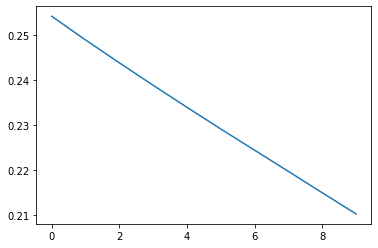

In [12]:
plt.plot(history.history['loss'], label = 'loss')

(5) Predict

In [7]:
y_pred = model.predict(test_in) 
print(y_pred)

[[0.36723185+0.01692254j 0.51554974+0.66085639j]
 [0.05769923+0.01692254j 0.59065129+0.66085639j]
 [0.62077996+0.01692254j 0.82387   +0.66085639j]
 [0.64269305+0.01692254j 0.49281552+0.66085639j]
 [0.30357099+0.01692254j 0.65799888+0.66085639j]]


In [8]:
a_npy

array([[0.7542195 +0.01692254j, 0.70500019+0.66085639j]])

## Multi-inputs, multi-output model

input1 = normalized FV, shape = (3, 25)

input2 = histogram, shape = (25) 

input3 = FV max, shape = (1)

output1 = normalized FV, shape = (25)

output2 = FV max, shape = (1)

In [3]:
N_lags = 25
N_convwindow = 3
reg_factor = 0.01

In [4]:
# (1) Register inputs
inp_fvnorm = keras.Input(shape = (N_convwindow, N_lags)) # normalized FV
inp_hist = keras.Input(shape = (N_convwindow, N_lags)) # histogram
inp_fvmax = keras.Input(shape = (N_convwindow, 1)) # fvmax

# (2) Mask to ignore the missing inputs
x1 = layers.Masking(mask_value = -1.0, input_shape = (N_convwindow, N_lags))(inp_fvnorm)
x2 = layers.Masking(mask_value = 0.0, input_shape = (N_convwindow, N_lags))(inp_hist)
# (3) Concatenate inputs2 & inputs3
x = layers.concatenate([x1, x2, inp_fvmax])
# (2) 1-layer CNN
x = layers.Conv1D(32, 3, activation = "relu", kernel_regularizer = keras.regularizers.L1(reg_factor))(x)
x = layers.Dropout(rate = 0.2)(x)
# Flatten
x = layers.Flatten()(x)
# Dense layers* 2 
x = layers.Dense(32, activation = "relu", kernel_regularizer = keras.regularizers.L1(reg_factor))(x)
x = layers.Dense(32, activation = "relu", kernel_regularizer = keras.regularizers.L1(reg_factor))(x)

out_fvnorm = layers.Dense(N_lags)(x) # normalized FV 
out_fvmax = layers.Dense(1)(x) # fvmax 

In [6]:
model = keras.Model(
    inputs = [inp_fvnorm, inp_hist, inp_fvmax], 
    outputs = [out_fvnorm, out_fvmax], 
    name = 'MIMO Conv1D')
model.summary()

Model: "MIMO Conv1D"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 25)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3, 25)]      0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 3, 25)        0           input_1[0][0]                    
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 3, 25)        0           input_2[0][0]                    
________________________________________________________________________________________

In [11]:
vec = np.arange(10)
arr = np.tile(vec, (3, 1))
print(arr)

[[0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]]


In [12]:
vec = np.array([4, 6, 1])
vec2 = np.reshape(vec, (3, 1))
print('vec shape = {}'.format(vec.shape))
print('vec2 shape = {}'.format(vec2.shape))

vec shape = (3,)
vec2 shape = (3, 1)


## Model summary of the successful CNN1D model for FV estimation

In [6]:
# Params
N_convwindow = 3
N_lags = 25
batch_size = 128
scaling = 20.0#15.0 / fvmax_refval 
reg_factor = 10**-8
reg_factor2 = 10**-12

# (1) Register inputs
inp_fv = keras.Input(shape = (N_convwindow, N_lags), name = 'in_fv_norm') # normalized FV, input_1
inp_hist = keras.Input(shape = (N_convwindow, N_lags),  name = 'hist') # histogram, input_2
# (2) Preprocessing: rescaling
x_hist = layers.experimental.preprocessing.Rescaling(scaling)(inp_hist)
######### Prediction of normalized FV #########
# (3) Concatenate inputs = normalized_fv, histogram
x = layers.concatenate([inp_fv, x_hist])
# (4) 1-layer CNN
x = layers.Conv1D(32, 3, activation = "relu", kernel_regularizer = keras.regularizers.L1(reg_factor))(x)
x = layers.Dropout(rate = 0.2)(x)
# Flatten
x = layers.Flatten()(x)
# (5) Dense layers* 4 
x = layers.Dense(32, activation = "relu", kernel_regularizer = keras.regularizers.L1(reg_factor))(x)
x = layers.Dense(32, activation = "relu", kernel_regularizer = keras.regularizers.L1(reg_factor))(x)
x = layers.Dense(32, activation = "relu", kernel_regularizer = keras.regularizers.L1(reg_factor))(x)
x = layers.Dense(32, activation = "relu", kernel_regularizer = keras.regularizers.L1(reg_factor))(x)
# Prediction
out_fv = layers.Dense(N_lags, name = 'pred_fv_norm')(x) # normalized FV


# Build model
model = keras.Model(
    inputs = [inp_fv, inp_hist], 
    outputs = [out_fv], 
    name = 'fv_estimate'
    )
model.summary()

Model: "fv_estimate"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hist (InputLayer)               [(None, 3, 25)]      0                                            
__________________________________________________________________________________________________
in_fv_norm (InputLayer)         [(None, 3, 25)]      0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 3, 25)        0           hist[0][0]                       
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 3, 50)        0           in_fv_norm[0][0]                 
                                                                 rescaling_1[0][0]      